Google Drive link for dataset:

https://drive.google.com/drive/folders/1gxeVZND0BZE_KabRlPHkIDwwJeRtDtVk?usp=sharing

## **Importing Libraries**

In [71]:
import numpy as npy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, random, cv2, pickle, json, itertools
import imgaug.augmenters as iaa
import imgaug.imgaug
import itertools
from tqdm import tqdm

from IPython.display import SVG
from tensorflow.keras.utils import plot_model, model_to_dot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.utils import class_weight
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Add, Input, Conv2D, Dropout, Activation, BatchNormalization, MaxPooling2D, ZeroPadding2D, AveragePooling2D, Flatten, Dense)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import *

## **Utility functions**


In [72]:
# For plotting the training and validation accuracy and loss graphs
import matplotlib.pyplot as plot
def display_training_results(training_history):
    plot.style.use("ggplot")
    figures, axises = plot.subplots(1, 2, figsize=(15, 5))

    # Plotting training and validation loss
    axises[0].set_title('Loss')
    axises[0].plot(training_history.history['loss'], label='Train Loss')
    axises[0].plot(training_history.history['val_loss'], label='Validation Loss')
    axises[0].legend(loc='upper right')

    # Plotting training and validation accuracy
    axises[1].set_title('Accuracy')
    axises[1].plot(training_history.history['accuracy'], label='Train Accuracy')
    axises[1].plot(training_history.history['val_accuracy'], label='Validation Accuracy')
    axises[1].legend(loc='lower right')

    plot.show()

def plot_confusion_matrix(cm,classes,title='Confusion Matrix',cmap=plt.cm.Blues):
    cm = cm.astype('float')/cm.sum(axis=1)[:,npy.newaxis]
    plt.figure(figsize=(6,6))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = npy.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        pass

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

## **Uploading the images**



Loading the images from the satellite-imagery-of-ships into numpy arrays, with labels [0,1] corresponding to the classes no-ship and ship.

In [73]:
datasets = ['/content/satellite-imagery-of-ships']

class_catogories = ["no-ship","ship"]

class_catogory_labels = {class_name:i for i,class_name in enumerate(class_catogories)}
num_classes = len(class_catogories)
class_catogory_labels

{'no-ship': 0, 'ship': 1}

In [74]:
def process_dataset():
    # Loading and preprocessing images and labels.
    all_images = []
    all_labels = []

    for dataset_path in datasets:
        for folder_name in filter(lambda x: x != '.ipynb_checkpoints', os.listdir(dataset_path)):
            current_label = class_catogory_labels[folder_name]
            folder_path = os.path.join(dataset_path, folder_name)

            for file_name in tqdm(os.listdir(folder_path)):
                image_path = os.path.join(folder_path, file_name)
                processed_image = process_image(image_path)
                all_images.append(processed_image)
                all_labels.append(current_label)

    return npy.array(all_images, dtype=npy.float32) / 255.0, npy.array(all_labels, dtype=npy.float32)

def process_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return cv2.resize(image, (48, 48))

images, labels = process_dataset()


100%|██████████| 331/331 [00:00<00:00, 1932.90it/s]


In [75]:
images.shape, labels.shape

((882, 48, 48, 3), (882,))

## **EDA of dataset**



In [76]:
n_labels = labels.shape[0]

_, count = npy.unique(labels, return_counts=True)

df = pd.DataFrame(data = count)
df['Class Label'] = class_catogories
df.columns = ['Count','Class-Label']
df.set_index('Class-Label',inplace=True)
df

,Count
Class-Label,
no-ship,551
ship,331


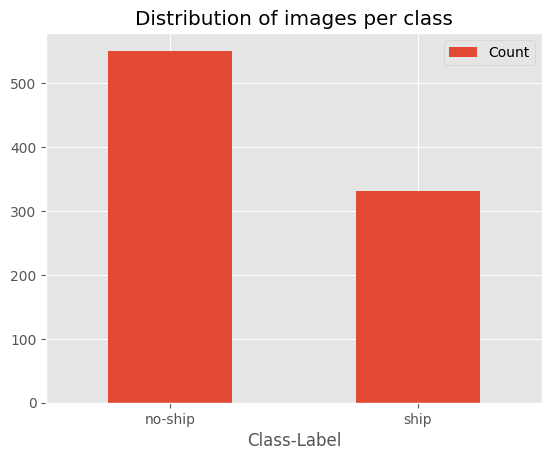

In [77]:
import matplotlib.pyplot as plt
# bar-plot - Bar plot is made to find the count of images per class

df.plot.bar(rot=0)
plt.title("Distribution of images per class");

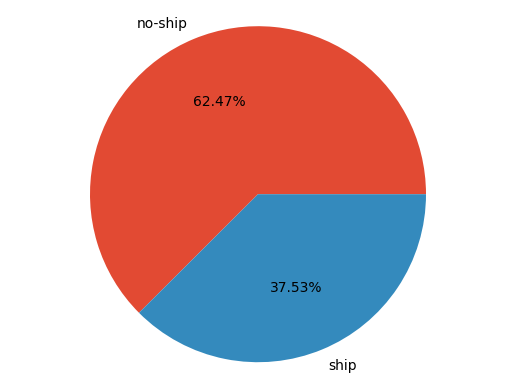

In [78]:
import matplotlib.pyplot as plt
# pie-plot - Pie plot is drawn to find the percentage of class distribution in the dataset

plt.pie(count,
       explode=(0,0),
       labels=class_catogories,
       autopct="%1.2f%%")
plt.axis('equal');

Since our data is skewed we will introduce class weights for each specific class. Each class is penalised with the specific class weight. Higher the class weight, greater the penalty.

The labels numpy array is one hot encoded using to_categorical from keras. This removes any uncessary bias in the dataset, by keeping the class at equal footing, with respect to labels.

In [79]:
labels = to_categorical(labels)

## **Training, Validation and Testing**



Instead of using train_test_split the images and labels arrays are randomly shuffled.

The training and validation dataset is used for training the model while the testing dataset is used for testing the model on unseen data. Unseen data is used for simulating real-world prediction.

In [80]:
npy.random.seed(42)
npy.random.shuffle(images)

npy.random.seed(42)
npy.random.shuffle(labels)

**Spliting of data**

70% - Training

20% - Validation

10% - Testing

In [81]:
import numpy as npy

def split_dataset(data, labels, train_split=0.7, val_split=0.2, seed=42):
    npy.random.seed(seed)
    shuffled_indices = npy.random.permutation(len(data))

    train_size = int(len(data) * train_split)
    val_size = int(len(data) * val_split)

    train_indices = shuffled_indices[:train_size]
    val_indices = shuffled_indices[train_size:train_size + val_size]
    test_indices = shuffled_indices[train_size + val_size:]

    return ((data[train_indices], labels[train_indices]),
            (data[val_indices], labels[val_indices]),
            (data[test_indices], labels[test_indices]))

(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = split_dataset(images, labels)

# Checking the shape of the split datasets
train_images.shape, val_images.shape, test_images.shape


((617, 48, 48, 3), (176, 48, 48, 3), (89, 48, 48, 3))

In [82]:
# Calculating class weights for both classes (no-ship, ship).
count_labels = train_labels.sum(axis=0)

classTotals = train_labels.sum(axis=0)
classWeight = {}

for i in range(0,len(classTotals)):
  classWeight[i] = classTotals.max()/classTotals[i]
  pass
print(classWeight)

{0: 1.0, 1: 1.6033756}


## **Creation of model**




In [83]:
from keras.layers import Conv2D, BatchNormalization, Activation

# convolutional_block - This function contains the convulotional layer, batch normalization and activation layers.
def convolutional_block(input_tensor, kernel_size, filters, stage, block, strides=2):
    conv_name = f'conv_{stage}{block}_branch'
    bn_name = f'bn_{stage}{block}_branch'

    # Convolutional layer
    x = Conv2D(filters, kernel_size=(kernel_size, kernel_size), strides=(strides, strides),
               padding='same', name=conv_name + '2a')(input_tensor)

    x = BatchNormalization(name=bn_name + '2a')(x)

    x = Activation('relu')(x)

    return x


In [84]:
from keras.layers import Input, ZeroPadding2D, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, Activation
from keras.models import Model

def build_basic_model(input_shape, num_classes):
    # Input layer
    input_tensor = Input(input_shape)

    # Initial Convolution and Batch Normalization
    x = ZeroPadding2D((5, 5))(input_tensor)
    x = Conv2D(16, (3, 3), strides=(2, 2), name='conv1', padding="same")(x)
    x = BatchNormalization(name='bn_conv1')(x)

    # Stage 2
    x = convolutional_block(x, 3, 32, 2, 'A', 1)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    # Stage 3
    x = convolutional_block(x, 5, 32, 3, 'A', 2)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    # Stage 4
    x = convolutional_block(x, 3, 64, 4, 'A', 1)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    # Output Layer
    x = Flatten()(x)
    x = Dense(64)(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation="relu")(x)
    output_tensor = Dense(num_classes, activation="softmax", name="fc" + str(num_classes))(x)

    model = Model(inputs=input_tensor, outputs=output_tensor, name='Feature_Extraction_and_FC')

    return model

In [85]:
model = build_basic_model(input_shape=(48,48,3),num_classes=2)
# plot_model(model,to_file='basic_model.png')
# SVG(model_to_dot(model).create(prog='dot',format='svg'))

**Compiling the Model**



In [86]:
from keras.models import Model
from keras.optimizers import Adam

# Initializing the Adam optimizer with a learning rate of 1e-3
adam_optimizer = Adam(learning_rate=1e-3)

model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [87]:
checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
logs = TensorBoard("logs")

## **Training model**



In [88]:
# The model is trained for 50 epochs with a batch size of 16.

epochs = 50
batch_size = 16

history_data_model = model.fit(train_images,train_labels,
                   steps_per_epoch=len(train_images)//batch_size,
                   epochs=epochs,
                   verbose=1,
                   validation_data=(val_images,val_labels),
                   validation_steps=len(val_images)//batch_size,
                   callbacks=[checkpoint, logs]
                   )

Epoch 1/50
38/38 [==============================] - ETA: 0s - loss: 0.6673 - accuracy: 0.6341
Epoch 1: val_accuracy improved from -inf to 0.66477, saving model to model_weights.h5
38/38 [==============================] - 8s 75ms/step - loss: 0.6673 - accuracy: 0.6341 - val_loss: 0.6582 - val_accuracy: 0.6648
Epoch 2/50
 3/38 [=>............................] - ETA: 1s - loss: 0.4866 - accuracy: 0.8039

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - ETA: 0s - loss: 0.4084 - accuracy: 0.8170
Epoch 2: val_accuracy did not improve from 0.66477
38/38 [==============================] - 2s 44ms/step - loss: 0.4084 - accuracy: 0.8170 - val_loss: 0.6045 - val_accuracy: 0.6307
Epoch 3/50
38/38 [==============================] - ETA: 0s - loss: 0.2978 - accuracy: 0.8644
Epoch 3: val_accuracy did not improve from 0.66477
38/38 [==============================] - 2s 61ms/step - loss: 0.2978 - accuracy: 0.8644 - val_loss: 0.6316 - val_accuracy: 0.6307
Epoch 4/50
38/38 [==============================] - ETA: 0s - loss: 0.2194 - accuracy: 0.9101
Epoch 4: val_accuracy did not improve from 0.66477
38/38 [==============================] - 3s 76ms/step - loss: 0.2194 - accuracy: 0.9101 - val_loss: 0.5906 - val_accuracy: 0.6534
Epoch 5/50
38/38 [==============================] - ETA: 0s - loss: 0.2159 - accuracy: 0.9227
Epoch 5: val_accuracy improved from 0.66477 to 0.69318, saving model to model_weights.h5
38/


Epoch 49: val_accuracy did not improve from 0.98295
38/38 [==============================] - 1s 34ms/step - loss: 0.0138 - accuracy: 0.9953 - val_loss: 0.1174 - val_accuracy: 0.9716


## **Plotting Loss and Accuracy**



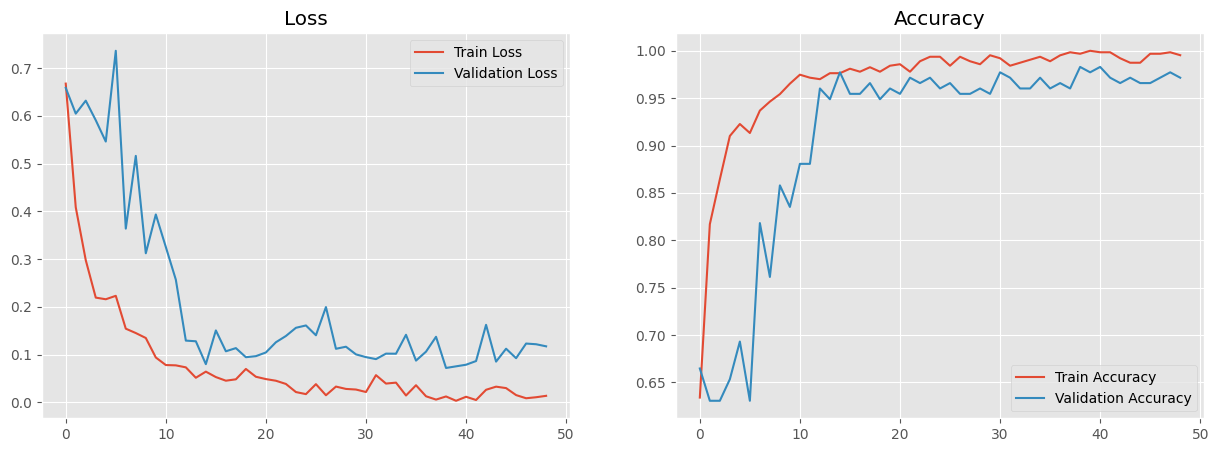

In [89]:
# The loss and accuracy for the training and validation datasets is plotted using the display_training_results function
display_training_results(history_data_model)

**Confusion Matrix for Validation dataset**



6/6 [==============================] - 0s 17ms/step


<Figure size 640x480 with 0 Axes>

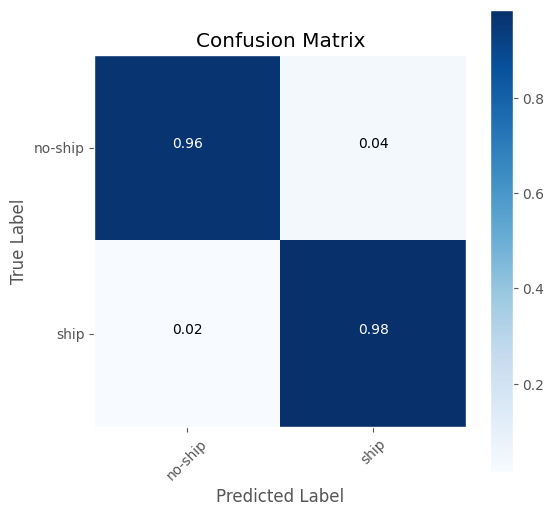

In [90]:
val_pred = model.predict(val_images)
val_pred = npy.argmax(val_pred,axis=1)
val_actual = npy.argmax(val_labels,axis=1)

cnf_mat = confusion_matrix(val_actual, val_pred)
npy.set_printoptions(precision=2)

plot.figure()
plot_confusion_matrix(cnf_mat,class_catogories)
plot.grid(None)
plot.show();

**Confusion Matrix for Testing Dataset**

3/3 [==============================] - 0s 20ms/step


<Figure size 640x480 with 0 Axes>

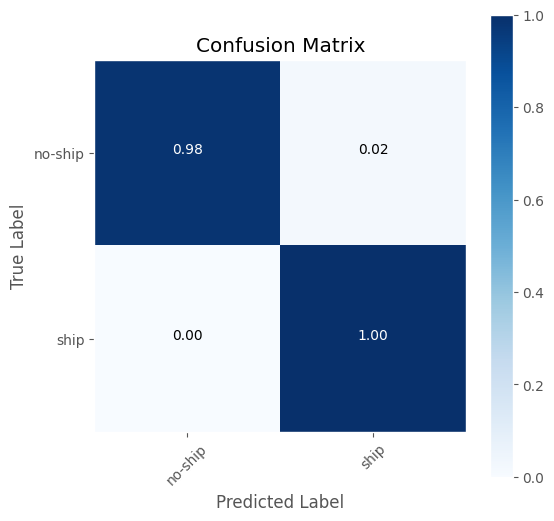

In [91]:
test_pred = model.predict(test_images)
test_pred = npy.argmax(test_pred,axis=1)

test_actual = npy.argmax(test_labels,axis=1)

cnf_mat_test = confusion_matrix(test_actual, test_pred)
npy.set_printoptions(precision=2)

plot.figure()
plot_confusion_matrix(cnf_mat_test,class_catogories)
plot.grid(None)
plot.show()

## **Checking the model**

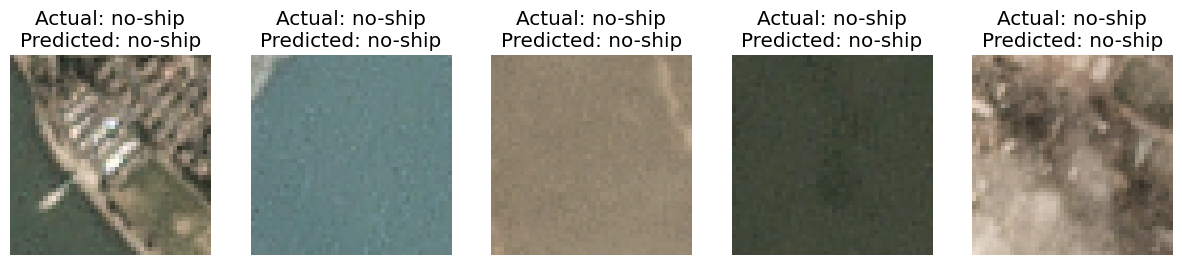

In [93]:
import matplotlib.pyplot as plt
import random

rnd_idx = random.sample(range(0, 56), 5)
class_labels = {i: class_name for (class_name, i) in class_catogory_labels.items()}
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for i, idx in enumerate(rnd_idx):
    axs[i].imshow(test_images[idx])
    axs[i].set_title("Actual: {}\nPredicted: {}".format(class_labels[test_actual[idx]], class_labels[test_pred[idx]]))
    axs[i].axis('off')

plt.show()


## **Saving the model**

In [94]:
model.save("ship-model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


References:

https://www.kaggle.com/datasets/rhammell/ships-in-satellite-imagery/data

https://www.kaggle.com/code/apollo2506/ship-detection-using-faster-r-cnn-part-1/notebook

https://www.kaggle.com/code/harshranjan01/ship-detection-using-faster-r-cnn-part1

https://blog.paperspace.com/faster-r-cnn-explained-object-detection/